# 第3周课后作业
## 一元变量的线性回归

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time # 用来记录算法的计算时间

plt.rcParams.update({
    "font.family": ["Times New Roman"],  # 使用 Times 字体
    "mathtext.fontset": "stix",        # 数学字体匹配 Times
    "font.size": 12                    # 默认字号
})

### 习题1
在对一个统计模型进行蒙特卡洛模拟时，我们通常会考虑多种不同的设置。为了简化讨论，我们仅考虑样本量变化的情况。设样本量$n$分别取$\{100, 300, 500, 1000\}$，并使用图表来汇报以下结果。请注意，在所有图表中，样本量应作为$x$轴。

#### 1.1 偏差盒状图
以$y$轴表示偏差，分别绘制并讨论两个参数估计量在$1000$次蒙特卡洛模拟中的偏差。

注：只需完善函数`plot_bias_boxplots_grouped`及相关调用。

In [2]:
def train_data_generation(n, rn):
    """
    生成样本数据 (x, y)

    参数:
        n : 样本量
        rn: 随机种子

    返回:
        x : n*1 的特征向量，从 N(2, 2^2) 中生成
        y : n*1 的标签向量，满足 y = 1 + x + ε，其中 ε ~ N(0,1)
    """
    np.random.seed(rn)
    x = np.random.normal(2, 2, (n,1))
    epsilon = np.random.normal(0, 1, (n,1))
    y = 1 + x + epsilon

    return x, y #打包输出相关结果

def estimation_summation(x,y):
    """
    使用逐项求和方法计算 OLS 估计量

    参数:
        x : n*1 特征向量
        y : n*1 标签向量

    返回:
        par_est : 长度为2的一维数组,[截距项估计值, 斜率项估计值]
    """

    n = len(x)
    #将截距项1加入到特征中，得到增广特征矩阵，记为aug_x
    aug_x = np.concatenate((np.ones_like(x),x), axis = 1)
    xx = np.zeros((2,2))
    xy = np.zeros((2,1))

    #计算'xx'和'xy'的求和
    for i in range(n):
        example_i = aug_x[i,:].reshape((2,1))
        xx += example_i @ example_i.transpose()
        xy += example_i * y[i]
    #计算'xx'的逆矩阵
    xx_inv = np.linalg.inv(xx)
    #得到估计量
    par_est = xx_inv @ xy
    
    return par_est.flatten()

def estimation_vectorization(x,y):
    """
    使用矩阵向量化方法计算 OLS 估计量

    参数:
        x : n*1 特征向量
        y : n*1 标签向量

    返回:
        par_est : 长度为2的一维数组[截距项估计值, 斜率项估计值]
    """
    #将截距项1加入到特征中，得到增广特征矩阵，记为aug_x
    aug_x = np.concatenate((np.ones_like(x),x), axis = 1)
    #通过X^TX获得'xx'，其中X是步骤2得到的增广矩阵
    xx = aug_x.transpose() @ aug_x
    #通过X^TY获得'xy'，其中Y的形状为nX1
    xy = aug_x.transpose() @ y
    #计算'xx'的逆矩阵
    xx_inv = np.linalg.inv(xx)  
    #获得估计器
    par_est = xx_inv @ xy 

    return par_est.flatten()

def calculate_bias(sample_sizes=(100, 300, 500, 1000), replications=1000, method=None):
    """
    进行蒙特卡洛模拟并计算 OLS 估计量的偏差

    参数:
        sample_sizes : 元组，表示要模拟的样本量集合
        replications : 每个样本量下的重复次数
        method       : 用于估计参数的函数

    返回:
        bias_results : 字典 {样本量: 2*1数组 [截距偏差, 斜率偏差]}
    """
    # 参数真值
    true_beta = np.array([1.0, 1.0])
    # 初始化结果容器
    bias_results = {n: np.zeros((replications, 2)) for n in sample_sizes}
    # 遍历样本量
    for n in sample_sizes:
        # 在每个样本量下进行 replications 次重复模拟
        for r in range(replications):
            # 生成数据
            x, y = train_data_generation(n=n, rn=r)
            # 调用指定估计方法
            estimates = method(x, y)
            # 保存偏差
            bias_results[n][r,:] = estimates - true_beta

    return bias_results

In [3]:
def plot_bias_boxplots_grouped(bias_results):
    """
    绘制偏差的分组盒图 (grouped boxplot)

    参数:
        bias_results : 字典 {样本量: 2*1数组 [截距偏差, 斜率偏差]}
                      
    返回:
        None
    """
    # 提取样本量及对应的截距、斜率偏差数据
    ns = sorted(bias_results.keys())  # 样本量
    bias_intercept = [bias_results[n][:, 0] for n in ns]
    bias_slope     = [bias_results[n][:, 1] for n in ns]

    # 初始化画布
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    positions = np.arange(len(ns)) * 3  # 每组盒图的横坐标位置

    # 截距盒图（左边）
    bp1 = ax.boxplot(
        bias_intercept,
        positions=positions - 0.4,
        widths=0.8,
        patch_artist=True,
        boxprops=dict(facecolor="lightgray")
    )

    # 斜率盒图（右边）
    bp2 = ax.boxplot(
        bias_slope,
        positions=positions + 0.4,
        widths=0.8,
        patch_artist=True,
        boxprops=dict(facecolor="white")
    )
    # 添加零基准线
    ax.axhline(0, linestyle="--", color="black", linewidth=1)
    # 设置坐标轴、标签、图例
    ax.set_xticks(positions)
    ax.set_xticklabels([str(n) for n in ns])
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Bias")
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Intercept", "Slope"], loc="upper right")
    # 调整布局并显示
    plt.tight_layout()
    plt.show()

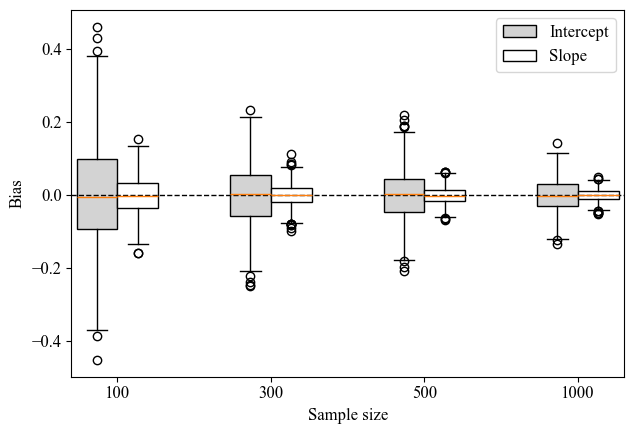

In [4]:
# 绘制求和方法的偏差盒状图
bias_summation = calculate_bias(method=estimation_summation)
plot_bias_boxplots_grouped(bias_summation)

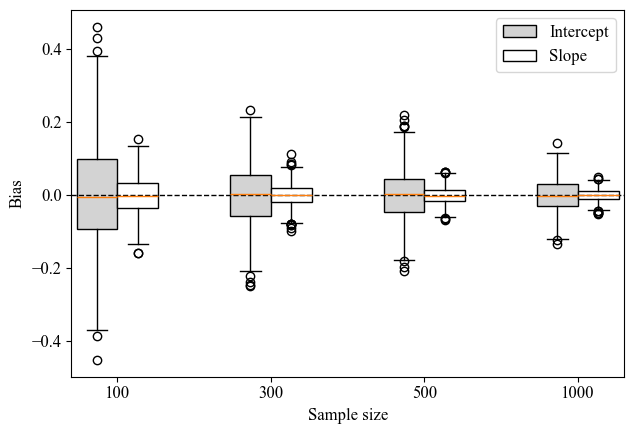

In [5]:
# 绘制向量化方法的偏差盒状图
bias_vectorization = calculate_bias(method=estimation_vectorization)
plot_bias_boxplots_grouped(bias_vectorization)

#### 1.2. 计算效率图表
展示两种估计方法的计算效率，不同方法应使用不同的颜色。绘制图表并对结果进行评论。

注：只需完善函数`plot_time_comparison`及相关调用。

In [6]:
def calculate_time(sample_sizes=(100, 300, 500, 1000), replications=1000, method=None):
    """
    计算不同样本量下某种估计方法的运行时间

    参数:
        sample_sizes : 元组或列表，要测试的样本量
        replications : int，每个样本量下的重复次数
        method : 估计方法函数

    返回:
        time_results : 字典 {样本量：耗时}
    """
    # 初始化结果容器
    time_results = {}
    # 遍历不同样本量
    for n in sample_sizes:
        # 记录开始时间
        T1 = time.time()
        for r in range(replications):
            # 生成数据，随机种子为r
            x, y = train_data_generation(n=n, rn=r)
            # 执行指定估计方法
            par_est = method(x,y)
        # 记录结束时间
        T2 = time.time()
        # 记录耗时
        time_results[n] = T2 - T1
        print(f'样本量:{n}, 方法:{method.__name__}, 耗时{time_results[n]:.4f}秒')
    return time_results

In [7]:
def plot_time_comparison(times_sum, times_vec):
    """
    绘制两种方法的计算效率比较折线图

    参数:
        times_sum : 字典 {样本量: 耗时}
        times_vec : 字典 {样本量: 耗时}

    返回:
        None
    """
    # 保证样本量有序
    ns = sorted(times_sum.keys())
    time_sum = [times_sum[n] for n in ns]
    time_vec = [times_vec[n] for n in ns]
    # 初始化画布
    plt.figure(figsize=(6.5, 4.5))
     # 绘制 Summation 方法的折线图
    plt.plot(ns, time_sum, marker="o", color="black", linestyle="-", label="Summation")
    # 绘制 Vectorization 方法的折线图
    plt.plot(ns, time_vec, marker="s", color="gray", linestyle="--", label="Vectorization")
    # 设置坐标轴和标题
    plt.xlabel("Sample size (n)")
    plt.ylabel("Computation time (seconds)")
    plt.title("Computation Efficiency Comparison")
    plt.legend()
    
    # 调整布局并显示
    plt.tight_layout()
    plt.show()

样本量:100, 方法:estimation_vectorization, 耗时0.0129秒
样本量:300, 方法:estimation_vectorization, 耗时0.0158秒
样本量:500, 方法:estimation_vectorization, 耗时0.0201秒
样本量:1000, 方法:estimation_vectorization, 耗时0.0315秒
样本量:100, 方法:estimation_summation, 耗时0.1522秒
样本量:300, 方法:estimation_summation, 耗时0.4762秒
样本量:500, 方法:estimation_summation, 耗时0.7529秒
样本量:1000, 方法:estimation_summation, 耗时1.4612秒


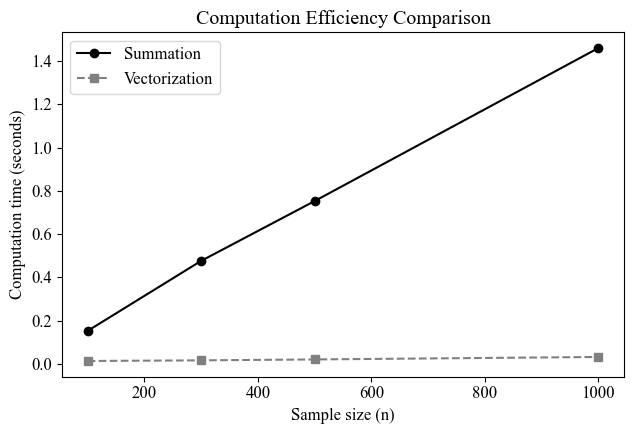

In [8]:
times_vectorization = calculate_time(method=estimation_vectorization)
times_summation = calculate_time(method=estimation_summation)
plot_time_comparison(times_summation, times_vectorization)

### 习题2

考虑 $n \in \{500, 1000, 1500, 2000, 3000\}$等5种不同的情况，计算基于求和法和向量法的所需要的计算时间，并将两种方法所需要的计算时间画在一张图中，并简要分析你所得到的结果。

注：只需调用`calculate_time`函数

样本量:500, 方法:estimation_vectorization, 耗时0.0442秒
样本量:1000, 方法:estimation_vectorization, 耗时0.0327秒
样本量:1500, 方法:estimation_vectorization, 耗时0.0434秒
样本量:2000, 方法:estimation_vectorization, 耗时0.0557秒
样本量:3000, 方法:estimation_vectorization, 耗时0.0779秒
样本量:500, 方法:estimation_summation, 耗时0.7344秒
样本量:1000, 方法:estimation_summation, 耗时1.4635秒
样本量:1500, 方法:estimation_summation, 耗时2.2490秒
样本量:2000, 方法:estimation_summation, 耗时3.0165秒
样本量:3000, 方法:estimation_summation, 耗时4.5261秒


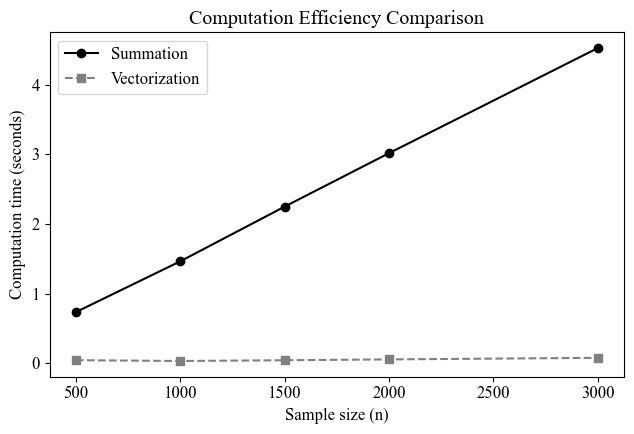

In [9]:
times_vectorization = calculate_time(sample_sizes=(500, 1000, 1500, 2000, 3000), method=estimation_vectorization)
times_summation = calculate_time(sample_sizes=(500, 1000, 1500, 2000, 3000), method=estimation_summation)
plot_time_comparison(times_summation, times_vectorization)

### 习题3
结合模型
$$ y_i = b_0 + w_0 x_i + \epsilon_i \quad (i = 1, \cdots, n), \tag{1}$$
其中 
$\epsilon_i \sim N(0, 1)$
为白噪声以及估计量
$$ (\hat{b},\hat{w})
=\left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)^{-1}\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}y_{i}
=(\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X})^{-1}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y}. \tag{4} $$
其中 
$\boldsymbol{\tilde{x}_{i}} = (1, x_i)^{\mathrm{T}}$, $\boldsymbol{X}=(\tilde{\boldsymbol{x}}_i,\ldots,\tilde{\boldsymbol{x}}_n)^\mathrm{т}\in\mathbb{R}^{n\times2}$ 
以及 
$\boldsymbol{Y}=(y_1,\ldots,y_n)^\mathrm{T}$. 
证明 (4) 中的估计量是统计无偏的，即 $E(\hat b) = b_0$ 以及 $E(\hat w) = w_0$.

解：记 $\theta = (b, w)^\mathrm{T}$, 我们有$y_i = (\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}} \theta_0 + \epsilon_i$，代入 (4):

$$
\begin{aligned}
\hat\theta
& = \left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)^{-1}\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}y_{i} \\ 
& = \left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)^{-1}\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}} [(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}} \theta_0 + \epsilon_i] \\
& = \left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)^{-1} \left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)\theta_0 + \left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)^{-1} \sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}\epsilon_i \\
E(\hat\theta | \boldsymbol{X}) & = \theta_0 + \left(\sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}}(\boldsymbol{\tilde{x}_{i}})^{\mathrm{T}}\right)^{-1} \sum_{i=1}^{n}\boldsymbol{\tilde{x}_{i}} E(\epsilon_i | \boldsymbol{X}) \\
& = \theta_0 \\
E(\hat\theta) & = E( E(\hat\theta | \boldsymbol{X}) ) = E(\theta_0) = \theta_0
\end{aligned}
$$


# 回归模型

### 习题1
基于估计量
$$\hat{\boldsymbol{\theta}}=(\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X})^{-1}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y} \tag{11}$$
所得到的 $\hat{\boldsymbol{\theta}}$ 是否满足 $\sum_{i=1}^n(y_i-\tilde{\boldsymbol{x}}_i^\mathrm{T}\hat{\boldsymbol{\theta}})=0$？为什么？

解：满足。注意到
$$ \boldsymbol{X}^{\mathrm{T}}(\boldsymbol{Y}-\boldsymbol{X}\hat{\boldsymbol{\theta}})=\boldsymbol{0},$$
其中 
$$
\boldsymbol{X}^{\mathrm{T}}
= (\tilde{\boldsymbol{x}}_1,\ldots,\tilde{\boldsymbol{x}}_n)
= \begin{bmatrix}
1 & 1 & \cdots & 1 \\
\boldsymbol{x}_1 & \boldsymbol{x}_2 & \cdots & \boldsymbol{x}_n \\
\end{bmatrix}
$$
因此我们有
$$
(1, 1, \cdots, 1) (\boldsymbol{Y}-\boldsymbol{X}\hat{\boldsymbol{\theta}}) = \sum_{i=1}^n(y_i-\tilde{\boldsymbol{x}}_i^\mathrm{T}\hat{\boldsymbol{\theta}}) = 0
$$

### 习题2

记 
$\boldsymbol{x}=(x_1,\ldots,x_d)^\mathrm{т}\in\mathbb{R}^d$, 
$\boldsymbol{a}=(a_1,\ldots,a_d)^\mathrm{т}\in\mathbb{R}^d$, 
$\boldsymbol{A}=(a_{ij})\in\mathbb{R}^{d\times d}$ 回答如下问题：

### 2.1 
假设向量 $\boldsymbol{a}$ 为定值，考虑关于 $\boldsymbol{x}$ 的函数 $f(\boldsymbol{x})=\boldsymbol{x}^\mathrm{T}\boldsymbol{a}=\sum_{i=1}^dx_ia_i$。对于$i=1,\ldots,d,$ 计算 $\partial f(\boldsymbol{x})/\partial x_i$ 并证明如下结论：
$$\frac{\partial f(\boldsymbol{x})}{\partial \boldsymbol{x}} = \boldsymbol{a}.$$

解：显然 $\partial f(\boldsymbol{x})/\partial x_i = a_i$。
由定义 
$$
\frac{\partial f(\boldsymbol{x})}{\partial \boldsymbol{x}} = 
\begin{bmatrix}
\partial f(\boldsymbol{x})/\partial x_1 \\
\vdots \\
\partial f(\boldsymbol{x})/\partial x_n
\end{bmatrix} = 
\begin{bmatrix}
a_1 \\
\vdots \\
a_n
\end{bmatrix} = 
\boldsymbol{a}.
$$

#### 2.2 
假设矩阵 $\boldsymbol{A}$为定值，考虑关于 $\boldsymbol{x}$的函数
$g(\boldsymbol{x})=\boldsymbol{x}^\mathrm{T}\boldsymbol{A}\boldsymbol{x}=\sum_{i=1}^d\sum_{j=1}^da_{ij}x_ix_j$。
对于$i=1,\ldots,d$ 以及 $j=1,\ldots,d$ 计算 
$\partial g(\boldsymbol{x})/\partial x_i$ 
以及 
$\partial^2g(\boldsymbol{x})/(\partial x_i\partial x_j)$，
并证明如下两个结论：
$$ \frac{\partial g(\boldsymbol{x})}{\partial\boldsymbol{x}}=(\boldsymbol{A}+\boldsymbol{A}^\mathrm{T})\boldsymbol{x}, $$
$$ \frac{\partial^2g(\boldsymbol{x})}{\partial\boldsymbol{x}^\mathrm{T}\partial\boldsymbol{x}}=\boldsymbol{A}+\boldsymbol{A}^\mathrm{T}。 $$

解：注意到
$$
 \frac{\partial g(\boldsymbol{x})}{\partial x_k }
= \sum_{j=1}^d a_{kj} x_j + \sum_{i=1}^d a_{ik}x_i
= \boldsymbol{a_{k \cdot}} \boldsymbol{x} + \boldsymbol{a^{\mathrm{T}}_{\cdot k}} \boldsymbol{x} \quad \forall k = 1, \ldots, d
$$
其中$\boldsymbol{a_{k \cdot}}$是$\boldsymbol{A}$的第$k$行，$\boldsymbol{a_{\cdot k}}$是$\boldsymbol{A}$的第$k$列。因此$\partial g(\boldsymbol{x})/\partial x_k $是列向量$(\boldsymbol{A}+\boldsymbol{A}^\mathrm{T})\boldsymbol{x}$的第$k$个元素。
由定义，
$$
\frac{\partial g(\boldsymbol{x})}{\partial\boldsymbol{x}} = 
\begin{bmatrix}
\partial g(\boldsymbol{x})/\partial x_1 \\
\vdots \\
\partial g(\boldsymbol{x})/\partial x_d
\end{bmatrix}
= (\boldsymbol{A}+\boldsymbol{A}^\mathrm{T})\boldsymbol{x}.
$$
注意到
$$
\frac{\partial^2 g(\boldsymbol{x})}{\partial x_k\partial x_l} = 
\frac{\partial (\sum_{j=1}^d a_{kj} x_j + \sum_{i=1}^d a_{ik}x_i)}{\partial x_l} = a_{kl} + a_{lk} \quad (\boldsymbol{A}+\boldsymbol{A}^\mathrm{T}\text{的$k$行$l$列元素})
$$
由定义
$$ \frac{\partial^2g(\boldsymbol{x})}{\partial\boldsymbol{x}^\mathrm{T}\partial\boldsymbol{x}}
=
\begin{bmatrix}
\frac{\partial^2g(\boldsymbol{x})}{\partial x_{1} \partial x_{1}} & \cdots & \frac{\partial^2g(\boldsymbol{x})}{\partial x_{1} \partial x_{d}} \\
\vdots &  & \vdots \\
\frac{\partial^2g(\boldsymbol{x})}{\partial x_{d} \partial x_{1}} & \cdots & \frac{\partial^2g(\boldsymbol{x})}{\partial x_{d}\partial x_{d}}
\end{bmatrix} 
= \boldsymbol{A}+\boldsymbol{A}^\mathrm{T}
$$

#### 2.3

结合代价函数
$$
\mathcal{J}(\boldsymbol{\theta})=\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\tilde{\boldsymbol{x}}_{i}^{\mathrm{T}}\boldsymbol{\theta})^{2}=\frac{1}{n}(\boldsymbol{Y}-\boldsymbol{X}\boldsymbol{\theta})^{\mathrm{T}}(\boldsymbol{Y}-\boldsymbol{X}\boldsymbol{\theta}), \tag{8}
$$
以及一阶条件
$$
\frac{\partial\mathcal{J}}{\partial\boldsymbol{\theta}}(\hat{\boldsymbol{\theta}})=0 \tag{9}
$$
证明参数估计量$\boldsymbol{\hat \theta}$为
$$
\hat{\boldsymbol{\theta}}=(\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X})^{-1}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y}
$$

解:
$$
\mathcal{J}(\boldsymbol{\theta}) =\frac{1}{n}(\boldsymbol{Y}-\boldsymbol{X}\boldsymbol{\theta})^{\mathrm{T}}(\boldsymbol{Y}-\boldsymbol{X}\boldsymbol{\theta})
= \frac{1}{n} \left( \boldsymbol{Y}^{\mathrm{T}} \boldsymbol{Y} - \boldsymbol{\theta}^{\mathrm{T}}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y} - \boldsymbol{Y}^{\mathrm{T}}\boldsymbol{X}\boldsymbol{\theta} + \boldsymbol{\theta}^{\mathrm{T}}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X}\boldsymbol{\theta} \right)
$$
注意到由2.1问，
$$
\frac{\partial \boldsymbol{\theta}^{\mathrm{T}}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y}}{\partial \boldsymbol{\theta}} = \frac{\partial \boldsymbol{Y}^{\mathrm{T}}\boldsymbol{X}\boldsymbol{\theta}}{\partial \boldsymbol{\theta}} = \boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y},
$$
由2.2问
$$
\frac{\partial \boldsymbol{\theta}^{\mathrm{T}}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X}\boldsymbol{\theta}}{\partial \theta} = 2 \boldsymbol{X}^{\mathrm{T}}\boldsymbol{X}
$$
因此，
$$
\frac{\partial \mathcal{J}(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = \frac{1}{n} \left( -2 \boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y} + 2 \boldsymbol{X}^{\mathrm{T}}\boldsymbol{X} \boldsymbol{\theta} \right) = 0
$$
$$
\hat{\boldsymbol{\theta}}=(\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X})^{-1}\boldsymbol{X}^{\mathrm{T}}\boldsymbol{Y}
$$